# Recurrent Neural Network Simulating a Dynamic System

In [77]:
! pip3 install sympy matplotlib

## 1. Definition of a Dynamic Process

Classes DynamicModel and DynamicProcess are defined file DynamicSystem.py. DynamicModel holds a description of a dynamic system in a symbolic form and as a differential equation. DynamicProcess helps to model a response (time series) of such model for a random input.   

In [86]:
from sympy.abc import s, t, y, x, y, z

In [87]:
from DynamicSystem import DynamicModel, DynamicProcess

### 1.1 Symbolic Definition of a Chosen System

In [88]:
G = 5*(s+1)/((s+3)*(s+2))
dynamic_model = DynamicModel(G)

In [89]:
dynamic_process = DynamicProcess(dynamic_model, 100)
dynamic_process.model

(5*s + 5)/((s + 2)*(s + 3))

### 1.2. Example of system responses for different inputs 

In [90]:
import matplotlib.pyplot as plt
import numpy as np

In [84]:
plt.figure(figsize=(25,25))
for i in range(12):
    t, u, y = dynamic_process.generate_time_series(10, 1000, new_inputs=True)
    plt.subplot(4,3,i+1)
    plt.plot(t, u)
    plt.plot(t, y)
plt.show()

KeyboardInterrupt: 

<Figure size 2500x2500 with 0 Axes>

## 2. Generate and Save Dataset

In [ ]:
import pandas as pd
import os
import pymongo

In [ ]:
# Set up pymongo client
client = pymongo.MongoClient('localhost', 27017)
db = client.DynamicSystem
time_series_collection = db.time_series 

In [ ]:
start = 20
stop = 40
for i in range(start, stop):
    t, u, y = dynamic_process.generate_time_series(10, 1000, new_inputs=True)
    data = {'t':t, 'u':u, 'y':y}
    df = pd.DataFrame(data)
    
    # Save to csv
    df.to_csv(f'dataset/{i}.csv', index=False)
    
    # Save to pymongo
    # time_series_collection.insert_one(df.to_json())

### 2.1. Prepare Dataset

In [91]:
import tensorflow as tf
from tensorflow import keras

#### 2.1.1. Import files

#### 2.1.2. Normalization and split

In [92]:
dataset_path = 'dataset/'
dataset_files = [ f'{dataset_path}/{file}' for file in os.listdir(dataset_path) if 'csv' in file]

val_samples = round(len(dataset_files) * 0.2)
train_ds = dataset_files[:-val_samples]
val_ds = dataset_files[-val_samples:]

In [ ]:
def normalize_dataset(files):
    
    # Concatante data from every file 
    
    # Calculate normalized values
    
    # Save them as additional columns
    
    
    pass

### 2.1. BatchBuilder

In [103]:
class TimeSeriesBatchBuilder(keras.utils.Sequence):
    """_summary_
    Helps to iterate over the dataset
    Args:
        keras (_type_): _description_
    """

    def __init__(self, dataset_files, window_size):
        self.dataset_files = dataset_files
        self.window_size = window_size
        self.file_len = len(pd.read_csv(self.dataset_files[0]))
        self.batch_size = self.file_len / self.window_size
        self.mean = 0 
        self.std = 0
    
    def __len__(self):
        return len(self.dataset_files)

    def __getitem__(self, idx):
        """Returns tuple (input, output) that corresponds to batch idx"""
        
        i = idx * self.batch_size
        batch_file = pd.read_csv(self.dataset_files[idx])
        
        x, y = [], []
        end = self.file_len - self.window_size
        for i in range(self.window_size, end):
            x_temp = np.concatenate((batch_file['u'][i:i+self.window_size].values, batch_file['y'][i:i+self.window_size].values))
            x.append(x_temp)
            y.append(batch_file['y'][i+self.window_size])
        
        return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

In [104]:
window_size = 5
train_gen = TimeSeriesBatchBuilder(train_ds, window_size=15)
val_gen = TimeSeriesBatchBuilder(val_ds, window_size=15)

In [ ]:
x, y = train_gen.__getitem__(0)

In [ ]:
x[300]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.83930206, 0.8392029 , 0.8391037 , 0.8389969 , 0.8388977 ,
       0.8387985 , 0.83869934, 0.83860016, 0.838501  , 0.8384018 ,
       0.8383026 , 0.83820343, 0.8380966 , 0.83799744, 0.83789825],
      dtype=float32)

In [ ]:
y[0]

0.50499725

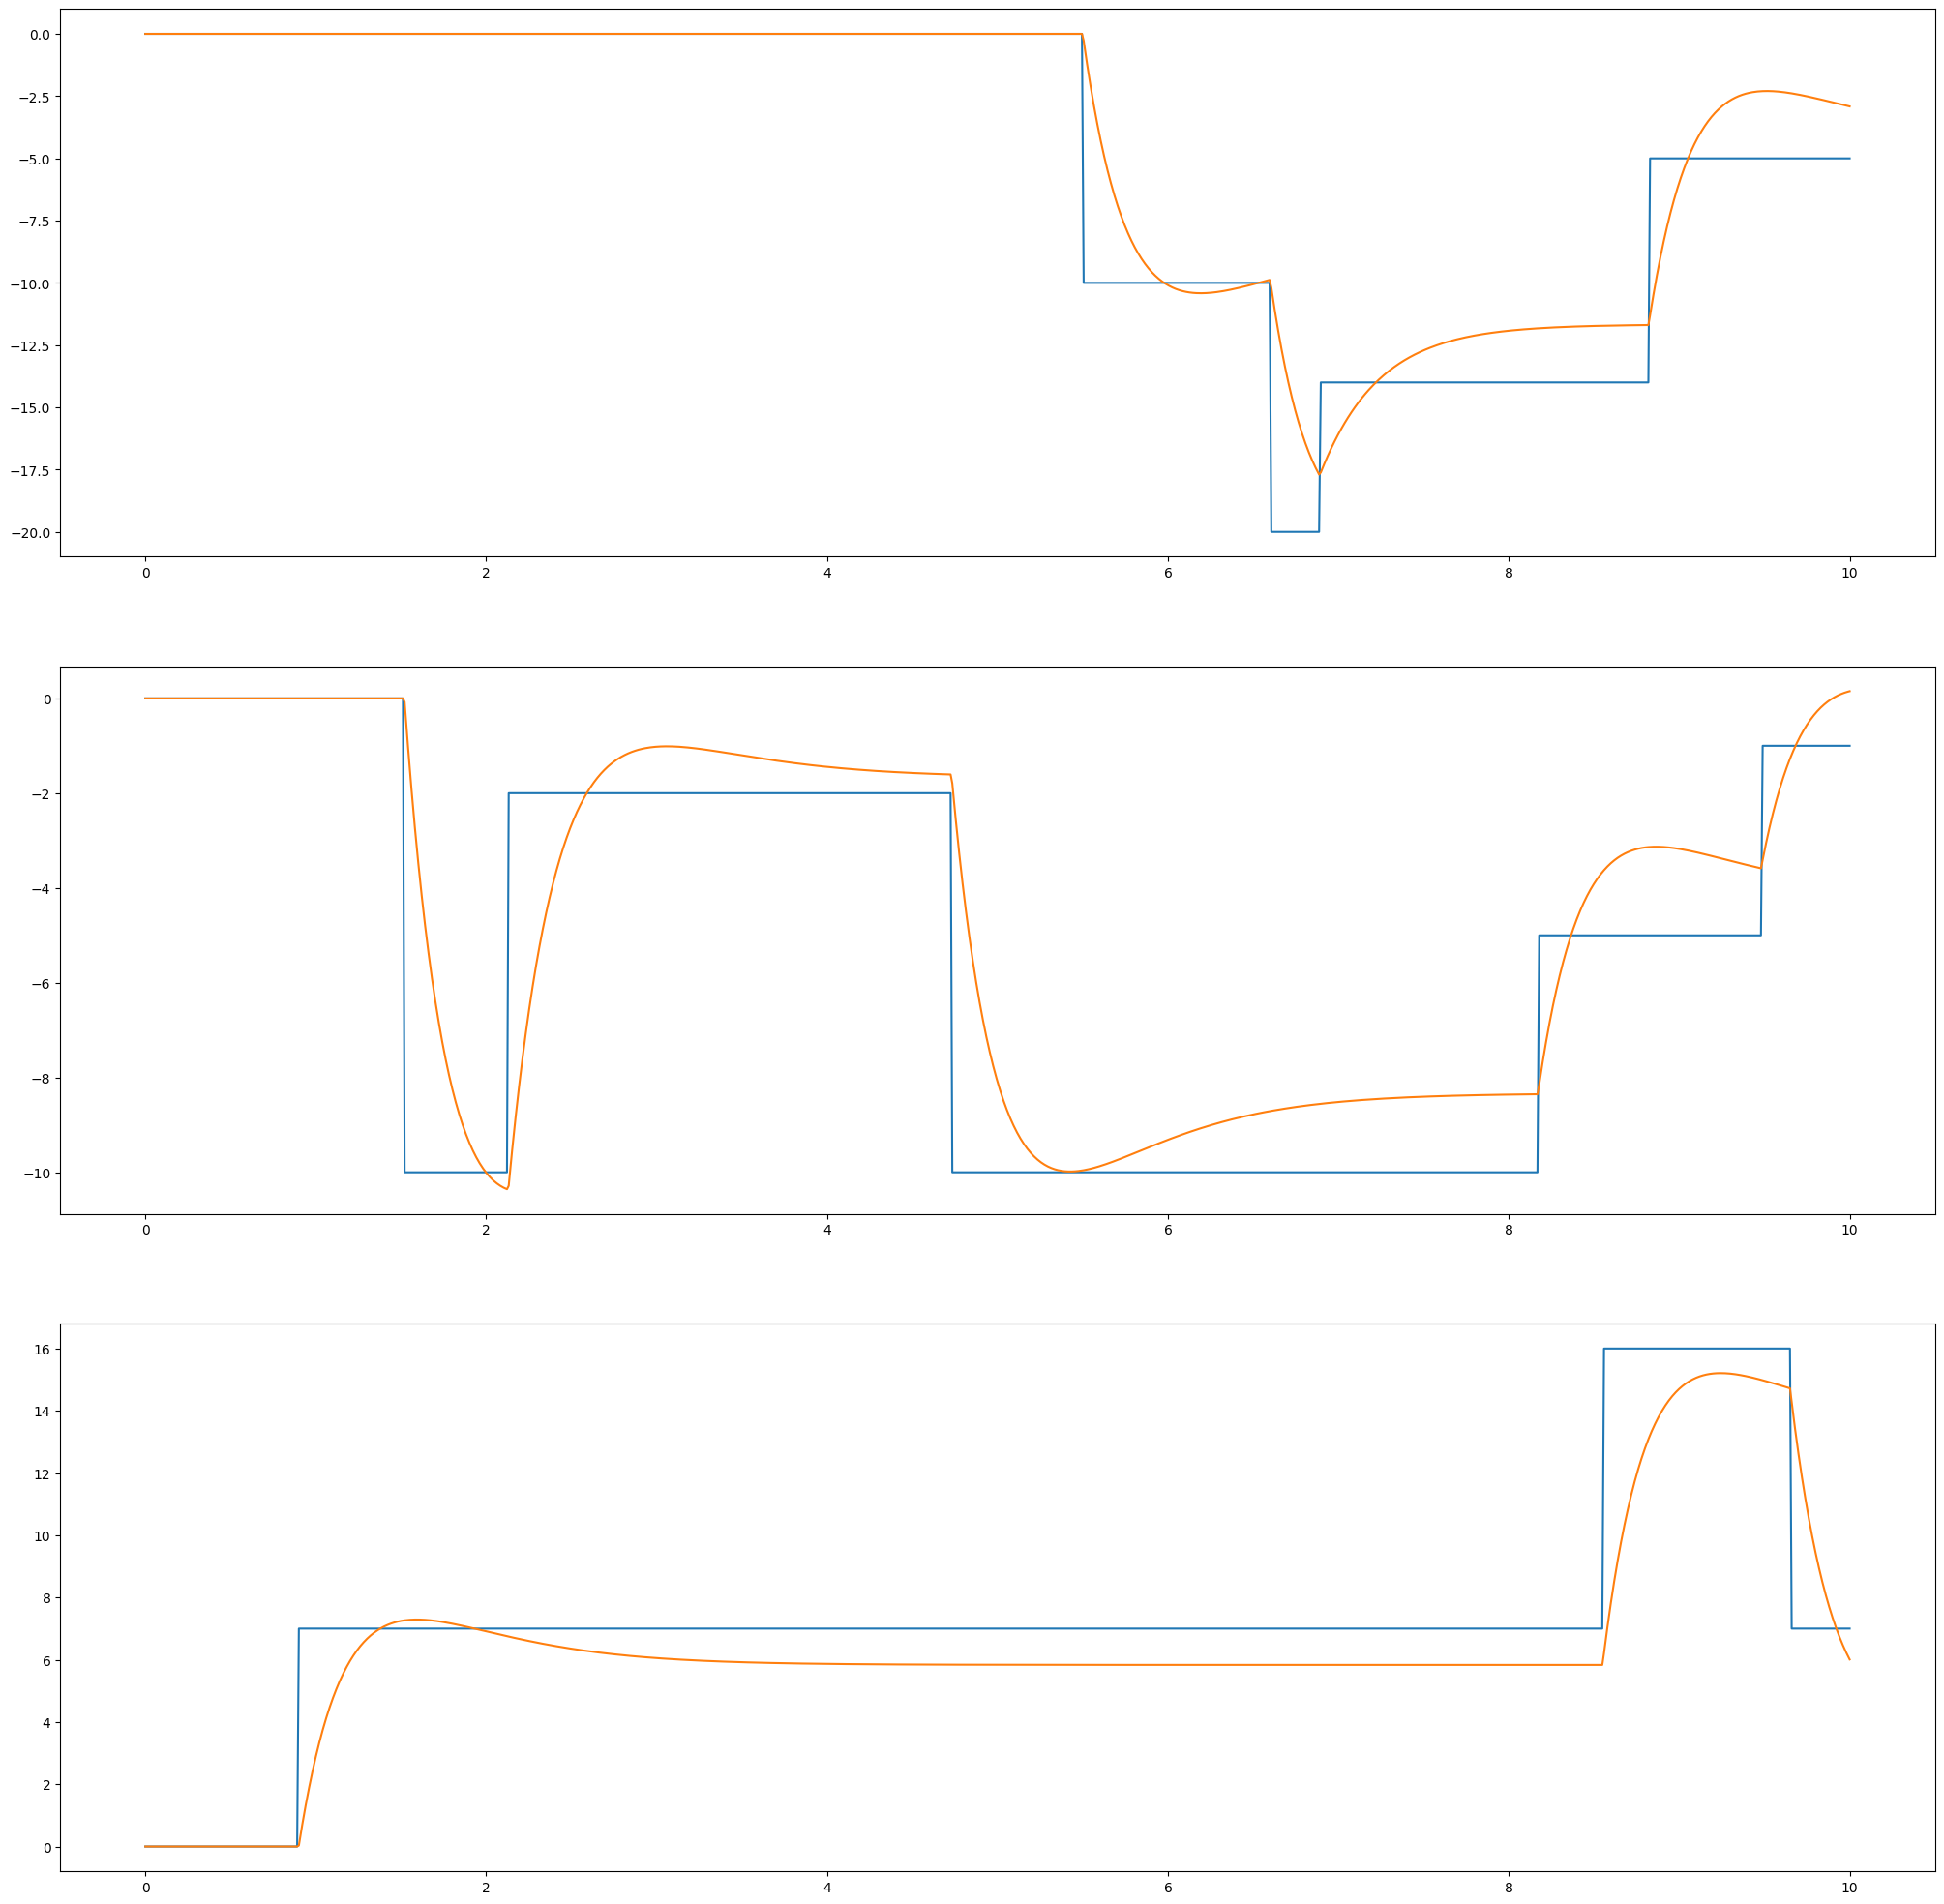

In [ ]:
plt.figure(figsize=(25,25))
u, y = train_gen.__getitem__(1)
t = ts = np.linspace(0,10,1000)
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(t, u[i])
    plt.plot(t, y[i])
plt.show()

### 2.2. WindowGenerator

Create WindowGenerator object for each batch? 

In [ ]:
class WindowGenerator:
    
    def __init__(self, dataset_path, split=(.6, .2, .2)):
        self.dataset_path = dataset_path
        dataset_files = [ f'{dataset_path}/{file}' for file in os.listdir(dataset_path)]
        self.total_window_size = 100
        self.train_df = pd.read_csv(dataset_files[0])
        self.val_df = pd.read_csv(dataset_files[1])
        self.test_df = pd.read_csv(dataset_files[2])
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
    def split_window(self, features):
        pass
    
    def plot(self):
        pass
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result


In [ ]:
window = WindowGenerator('dataset')

In [ ]:
window.train_df

,t,u,y
0,0.00000,0.0,0.000000
1,0.01001,0.0,0.000000
2,0.02002,0.0,0.000000
3,0.03003,0.0,0.000000
4,0.04004,0.0,0.000000
...,...,...,...
995,9.95996,7.0,5.833300
996,9.96997,2.0,5.588999
997,9.97998,2.0,5.353300
998,9.98999,2.0,5.127001


### Prepare Baseline model for benchmarking

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

## 3. Prepare Data

## 4. Recurrent Neural Network

### 4.1. Standard LSTM network

In [95]:
import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential

In [105]:
def rnn_model():
    
  model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(40, return_sequences=True),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dense(1),
  ])

  return model
  
  
def rnn_model_2(params, input_shape):
  model = Sequential()
  model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, 1)))
  model.add(Dropout(rate=params["dropout"]))

  model.add(LSTM(units=params["lstm_units"], return_sequences=True))
  model.add(Dropout(rate=params["dropout"]))

  model.add(LSTM(units=params["lstm_units"], return_sequences=True))
  model.add(Dropout(rate=params["dropout"]))

  model.add(LSTM(units=params["lstm_units"], return_sequences=False))
  model.add(Dropout(rate=params["dropout"]))

  model.add(Dense(1))

  model.compile(loss=params["loss"],
                optimizer=params["optimizer"],
                metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
  
  model.summary()

  return model

def rnn_model_3():
  learning_rate = 0.001
  batch_size = 256
  epochs = 10
    
  model = Sequential()
  model.add(keras.layers.Input(shape=(15, 1)))
  model.add(keras.layers.LSTM(64, return_sequences=True))
  model.add(keras.layers.LSTM(32, return_sequences=True))
  model.add(keras.layers.Dense(1))
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
  model.summary()
    
  return model 
  
  

In [106]:
params = {
	"loss": "mean_squared_error",
	"optimizer": "adam",
	"dropout": 0.2,
	"lstm_units": 90,
	"epochs": 30,
	"batch_size": 128,
	"es_patience" : 10
}

model = rnn_model_2(params=params, input_shape=30)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 30, 90)            33120     
                                                                 
 dropout_20 (Dropout)        (None, 30, 90)            0         
                                                                 
 lstm_24 (LSTM)              (None, 30, 90)            65160     
                                                                 
 dropout_21 (Dropout)        (None, 30, 90)            0         
                                                                 
 lstm_25 (LSTM)              (None, 30, 90)            65160     
                                                                 
 dropout_22 (Dropout)        (None, 30, 90)            0         
                                                                 
 lstm_26 (LSTM)              (None, 90)               

In [ ]:
model = rnn_model_3()

2022-10-30 11:21:56.068921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-30 11:21:56.069499: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-30 11:21:56.069534: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-Szymon): /proc/driver/nvidia/version does not exist
2022-10-30 11:21:56.072004: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            12416     
                                                                 
 dense (Dense)               (None, 15, 1)             33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [110]:
history = model.fit(train_gen, epochs=15, validation_data=val_gen)

Epoch 1/15
32/32 [==============================] - 26s 792ms/step - loss: 2.3744 - root_mean_squared_error: 1.5409 - mean_absolute_error: 0.9907 - val_loss: 1.6144 - val_root_mean_squared_error: 1.2706 - val_mean_absolute_error: 1.0402
Epoch 2/15
32/32 [==============================] - 27s 860ms/step - loss: 2.8757 - root_mean_squared_error: 1.6958 - mean_absolute_error: 1.2507 - val_loss: 1.5744 - val_root_mean_squared_error: 1.2548 - val_mean_absolute_error: 1.0231
Epoch 3/15
32/32 [==============================] - 32s 1s/step - loss: 1.5031 - root_mean_squared_error: 1.2260 - mean_absolute_error: 0.7210 - val_loss: 0.8261 - val_root_mean_squared_error: 0.9089 - val_mean_absolute_error: 0.5597
Epoch 4/15
32/32 [==============================] - 43s 1s/step - loss: 1.3346 - root_mean_squared_error: 1.1552 - mean_absolute_error: 0.6933 - val_loss: 0.9177 - val_root_mean_squared_error: 0.9580 - val_mean_absolute_error: 0.7428
Epoch 5/15
32/32 [==============================] - 36s 1s

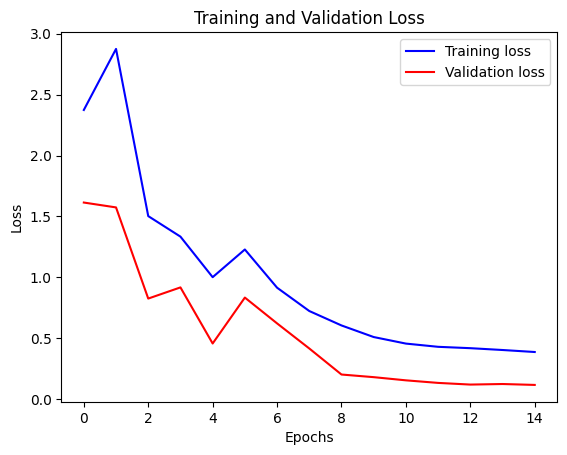

In [111]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [162]:
def compare_plots(model, window_size=15):
    plt.figure(figsize=(25,25))
    t, u, y = dynamic_process.generate_time_series(10, 1000, new_inputs=True)
    
    y_pred = []
    u_extended = np.concatenate((np.zeros(window_size), u))
    y_window = np.zeros(window_size)
    for i in range(len(t)):
        
        input_for_pred = np.array([np.concatenate((u_extended[i:i+window_size], y_window))])
        y_hat = model.predict(input_for_pred)[0][0]
        y_pred.append(y_hat)
        
        y_window = np.roll(y_window, -1)
        y_window[window_size-1] = y_hat
    
    plt.plot(t, u)
    plt.plot(t, y)
    plt.plot(t, y_pred)
    plt.show()

1/1 [==============================] - 0s 44ms/step


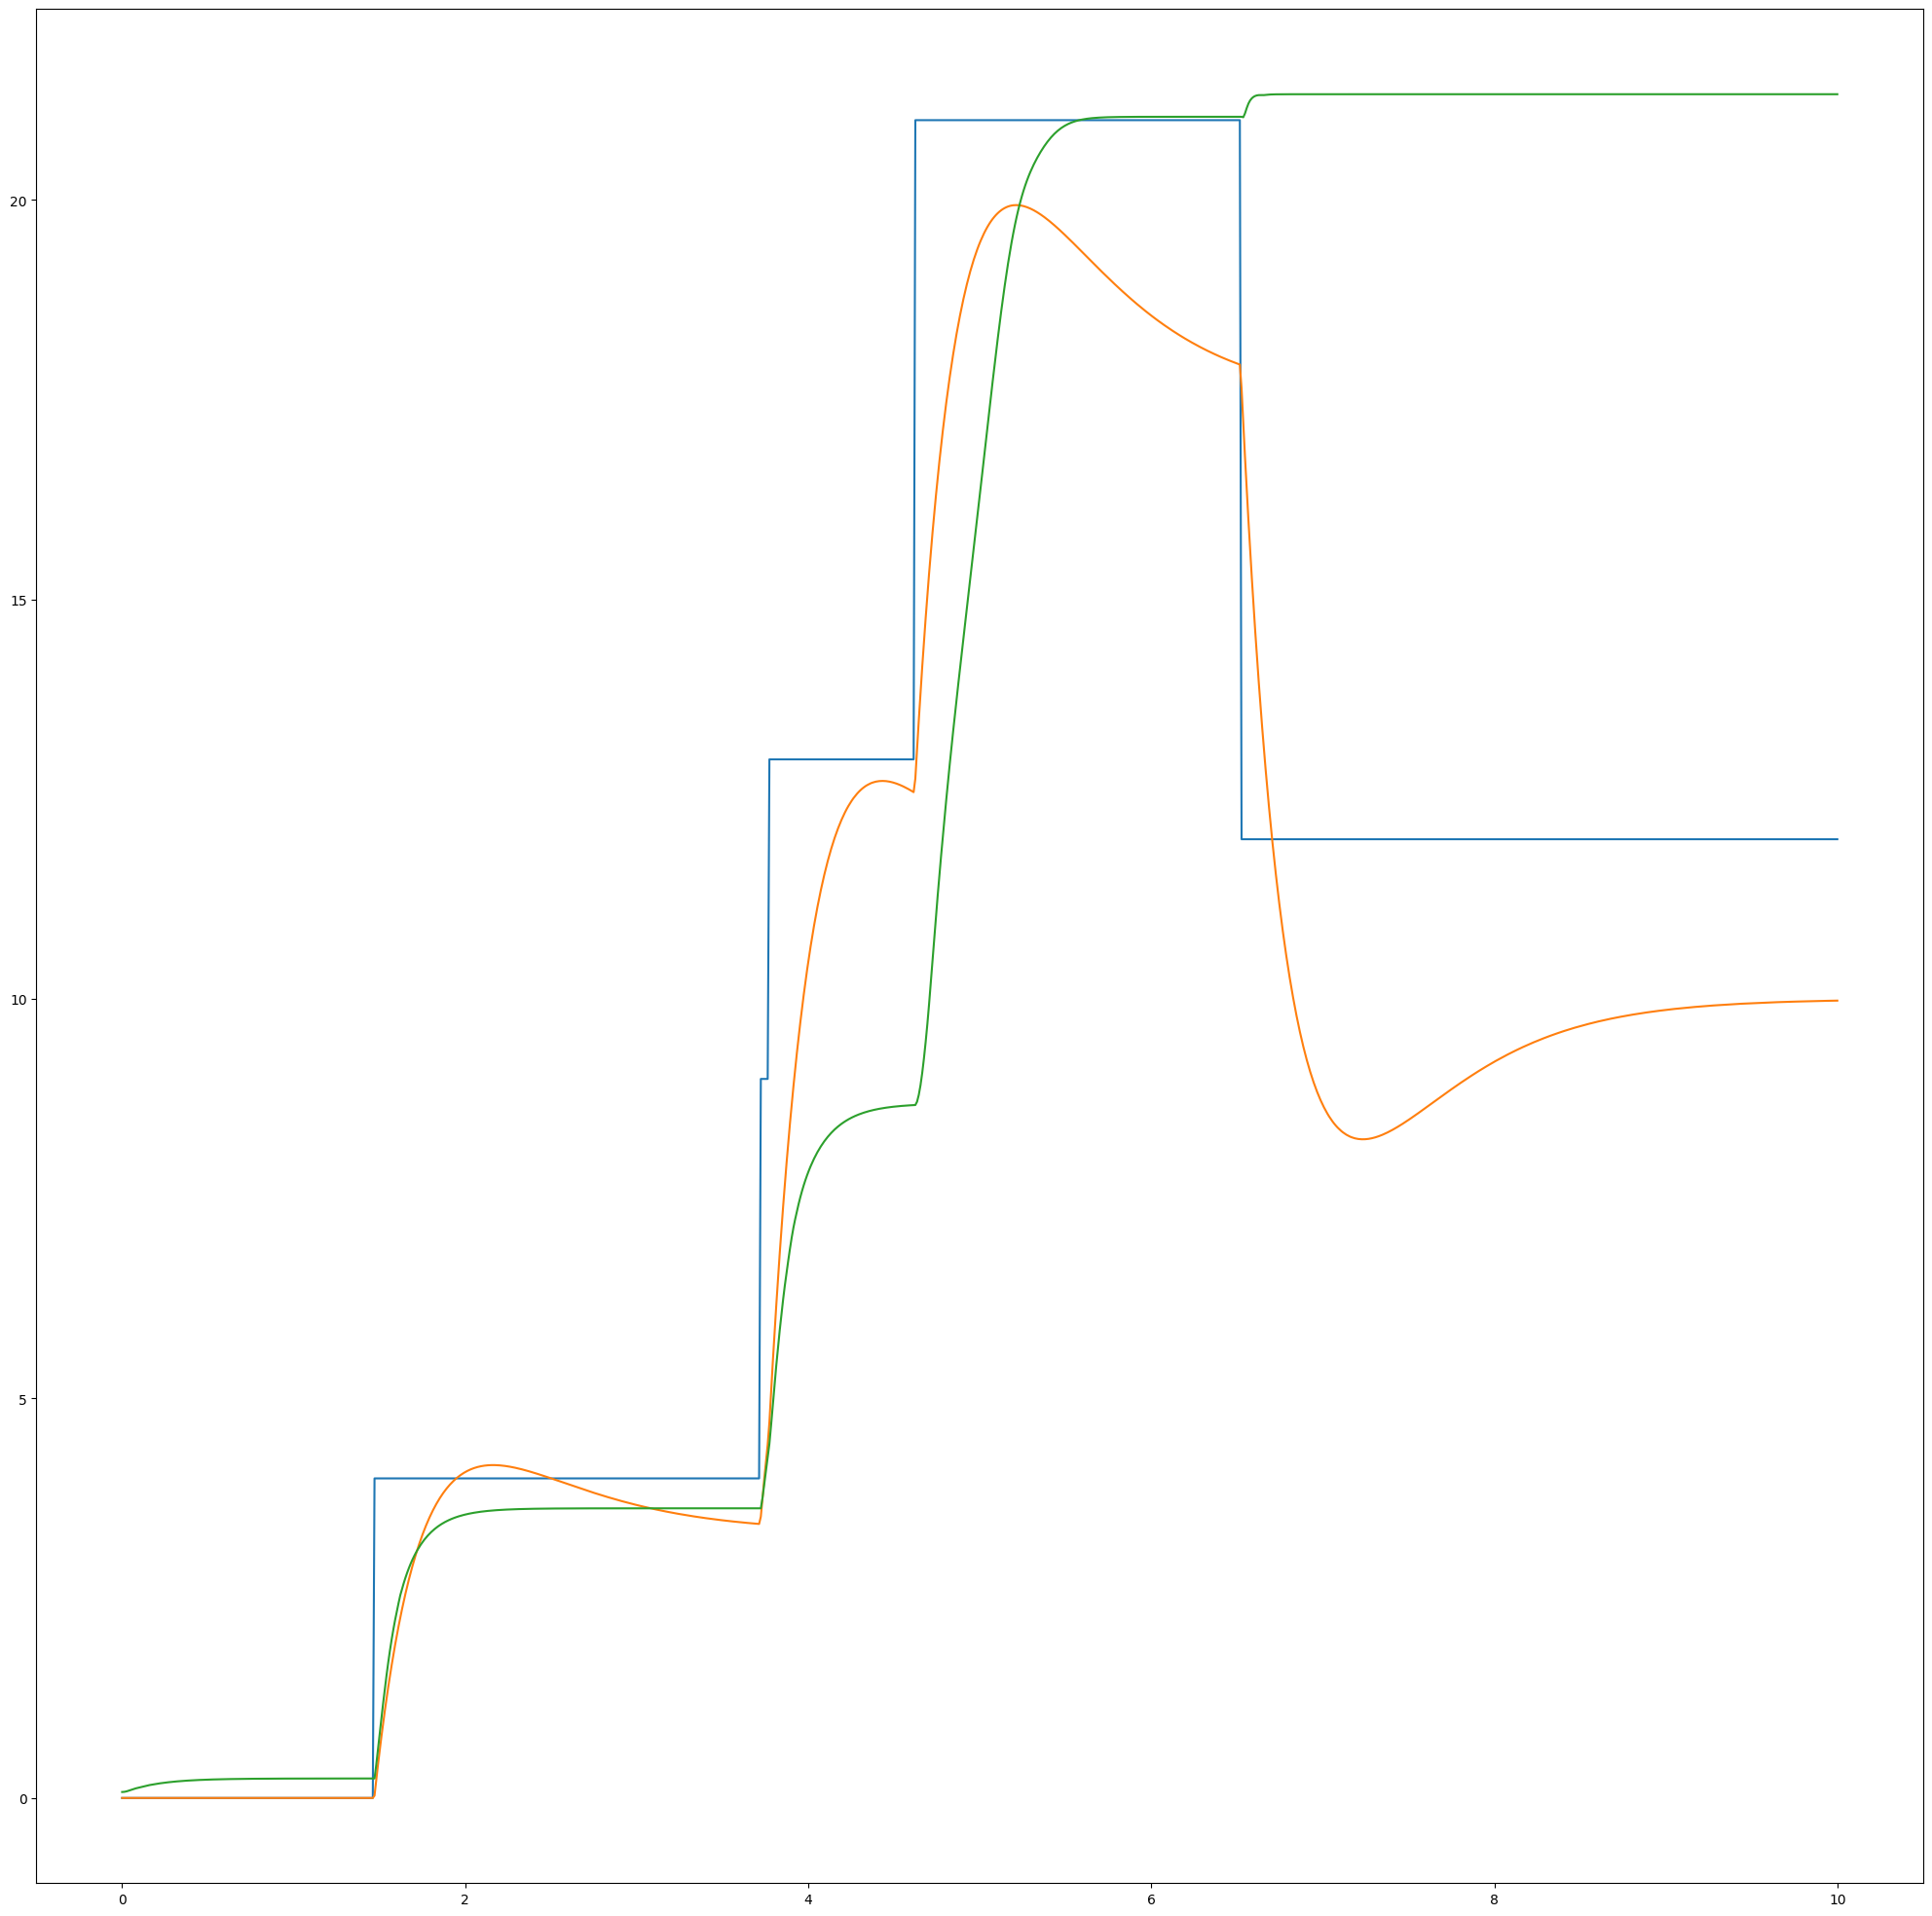

In [163]:
compare_plots(model, window_size=15)

In [ ]:
def show_plot():
    pass